<a href="https://colab.research.google.com/github/Leox48/Disinformation-Threat-Intelligence/blob/main/DistilBertFineTuned_Multi_Class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installazione requisiti

In [1]:
!pip  install transformers

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
import transformers

In [4]:
print(transformers.__version__)


4.42.4


In [5]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Pre-Processing Dataset

In [6]:
# Specifica il percorso del file Excel
file_path = '/content/Tupling.xlsx'

# Legge il file Excel e lo converte in un DataFrame
df = pd.read_excel(file_path)

df = df.sort_values(by="ID ARTICOLO", ascending=True)

In [7]:
df['CAMPAGNA'].unique()
#len(df['CAMPAGNA'].unique())

array(['Viral Fake Election News', 'Local Report', 'Metric Media',
       'Fake Dementia Solution', 'American Action News',
       'Hyperpartisan in 2016 American Politic Elections',
       'Russian troll accounts during 2016 U.S. presidential election',
       'Alabama Power Positive Reputation ', 'Hawking Code Scam',
       'Energy foes campaign ', 'A Cure for Wellnes Promotion',
       'Climate Change Denial',
       'Covid trigger Neurological Degenerative Diseases',
       'Covid vaccines cospiration theories',
       'General campaign against women',
       'False scientific health information',
       'Mark Zuckerberg Diffamation',
       'Ginger is better than chemiotherapy ',
       'Food Babe - False food Allarmism ',
       'Dmitry Medvedev confirm alien existence ',
       ' Covid vaccines cause autism', 'Cannabis cure for cancer',
       'Covid vaccines increase deaths',
       'Doctors found dead after cancer discovery',
       'Vaccines general disinformation', 'Indian  

Mapping nomi in interi -> Labels (il modello comprende solo numeri)

In [8]:
df['labels'] = df['CAMPAGNA'].astype('category').cat.codes
df.head()

,TUPLA,ID ARTICOLO,CAMPAGNA,labels
0,News outlets - are reporting - on the news,1,Viral Fake Election News,42
1,Pope Francis - asks - Americans to vote for Do...,1,Viral Fake Election News,42
2,Pope Francis - believes - a strong and free Am...,1,Viral Fake Election News,42
3,Pope Francis - believes - the Rule of Law is t...,1,Viral Fake Election News,42
10,Pope Francis - released - a statement,1,Viral Fake Election News,42


Mapping inverso

In [9]:
# Creazione della mappatura label -> campagna
label_to_campaign = dict(enumerate(df['CAMPAGNA'].astype('category').cat.categories))

# Visualizzazione della mappatura
print(label_to_campaign)

{0: ' Covid vaccines cause autism', 1: '2016 US presidential elections', 2: '5 meter tall human', 3: 'A Cure for Wellnes Promotion', 4: 'Alabama Power Positive Reputation ', 5: 'American Action News', 6: 'Cannabis cure for cancer', 7: 'Climate Change Denial', 8: 'Clone Zone ', 9: 'Coronavirus and vaccines in America', 10: 'Counter criticism of Turkey in foreign media', 11: 'Covid trigger Neurological Degenerative Diseases', 12: 'Covid vaccines cospiration theories', 13: 'Covid vaccines increase deaths', 14: 'Disinformation on armed forces for Ukraine', 15: 'Dmitry Medvedev confirm alien existence ', 16: 'Doctors found dead after cancer discovery', 17: 'Energy foes campaign ', 18: 'Fake Dementia Solution', 19: 'Fake News on OpIndia between January 2018 and June 2020', 20: 'Fake News on child protective services', 21: 'False scientific health information', 22: 'Food Babe - False food Allarmism ', 23: 'Fraudolent fact check on Covid19 in India', 24: 'General campaign against women', 25: '

Suddivisione stratistificata del dataset che permette di non saltare alcuna campagna

In [10]:
from sklearn.model_selection import train_test_split

# Step 1: Suddivisione in train e temp (80% train, 20% temp)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['CAMPAGNA'], random_state=42)

# Step 2: Suddivisione di temp in val e test (50% val, 50% test, quindi 10% ciascuno del totale originale)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['CAMPAGNA'], random_state=42)


In [11]:
# len(train_df['CAMPAGNA'].unique())
# len(val_df['CAMPAGNA'].unique())
# len(test_df['CAMPAGNA'].unique())

Suddivisione dataset train, test, validation

In [12]:
train_texts = train_df['TUPLA'].to_list()
train_labels= train_df['labels'].to_list()

val_texts = val_df['TUPLA'].to_list()
val_labels = val_df['labels'].to_list()

test_texts = test_df['TUPLA'].to_list()
test_labels = test_df['labels'].to_list()
test_ids = test_df['ID ARTICOLO'].to_list()

Encodings: Trasformazione delle tuple in vettori che il modello possa comprendere

In [13]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

test_encodings = tokenizer(test_texts, truncation = True, padding = True )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [14]:
# print(train_encodings)

Funzioni di creazione dataset in formato pytorch per il modello

In [15]:
import torch
from torch.utils.data import Dataset

class TensorDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [16]:
from torch.utils.data import Dataset

class TestDataset(Dataset):
    def __init__(self, encodings, texts, labels, ids):
        self.encodings = encodings
        self.texts = texts  # Manteniamo i testi originali
        self.labels = labels  # Manteniamo le label originali
        self.ids = ids  # Manteniamo gli IDs originali

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['text'] = self.texts[idx]  # Aggiungi il testo originale per riferimento
        item['label'] = self.labels[idx]  # Aggiungi la label originale per riferimento
        item['idArt'] = self.ids[idx]  # Aggiungi l'idArt originale per riferimento
        return item

    def __len__(self):
        return len(self.texts)


In [17]:
# Creazione del dataset PyTorch
train_dataset = TensorDataset(train_encodings, train_labels)
val_dataset = TensorDataset(val_encodings, val_labels)
test_dataset = TestDataset(test_encodings, test_texts, test_labels, test_ids)

##Modello - ReLoading modello già trainato

In [ ]:
# # To load the model and tokenizer later:
# # from transformers import AutoModelForSequenceClassification, AutoTokenizer
# # model = AutoModelForSequenceClassification.from_pretrained('./saved_model')
# # tokenizer = AutoTokenizer.from_pretrained('./saved_tokenizer')

##Modello - Definizione

In [18]:
num_labels=len(train_df['CAMPAGNA'].unique())

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
# Step 3: Define the Model and Training Arguments
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)  # Adjust num_labels as per your dataset

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from datasets import load_metric
import numpy as np
metric_accuracy = load_metric("accuracy")
metric_f1 = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)
    f1 = metric_f1.compute(predictions=predictions, references=labels, average='weighted')
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],

    }

<ipython-input-20-38a15d4435b9>:3: FutureWarning:

load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate



The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [21]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=13,
    weight_decay=0.01,
)

#6+6+4+8 (overfitting al 4 training dopo 2 epoche -> 12 epoc?)

In [22]:
# Step 5: Train the Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

##Modello - Training

In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.740803,0.570156,0.481637
2,No log,1.264611,0.682628,0.634612
3,1.901000,1.098392,0.718263,0.670476
4,1.901000,0.945418,0.746102,0.706457
5,0.871800,0.868991,0.775056,0.744182
6,0.871800,0.832081,0.782851,0.760361
7,0.490800,0.815564,0.792873,0.775116
8,0.490800,0.775583,0.801782,0.787863
9,0.291900,0.775055,0.814031,0.803380
10,0.291900,0.778880,0.819599,0.809811


TrainOutput(global_step=2925, training_loss=0.6605699457673945, metrics={'train_runtime': 888.182, 'train_samples_per_second': 105.15, 'train_steps_per_second': 3.293, 'total_flos': 2563138170076224.0, 'train_loss': 0.6605699457673945, 'epoch': 13.0})

In [24]:
# Step 6: Evaluate the Model
trainer.evaluate()

{'eval_loss': 0.7707125544548035,
 'eval_accuracy': 0.8296213808463252,
 'eval_f1': 0.822154335322795,
 'eval_runtime': 2.8748,
 'eval_samples_per_second': 312.365,
 'eval_steps_per_second': 10.088,
 'epoch': 13.0}

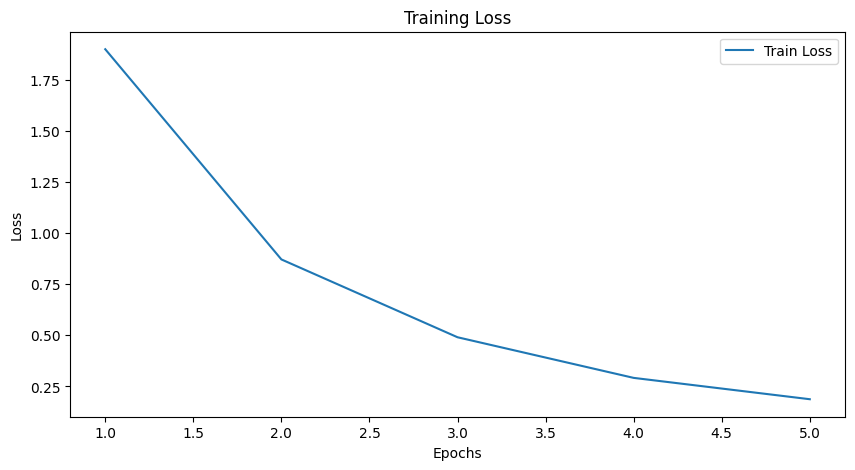

In [25]:
# Supponendo che trainer.state.log_history contenga la storia dei log
log_history = trainer.state.log_history

# Estrai i dati di training
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
train_accuracy = [entry['train_accuracy'] for entry in log_history if 'train_accuracy' in entry]

# Crea una lista di epoche per il plot
epochs = range(1, len(train_loss) + 1)

# Crea il plot
plt.figure(figsize=(10, 5))

# Plot della Loss
plt.plot(epochs, train_loss, label='Train Loss')


# Plot dell'Accuracy (su un asse secondario)
#plt.plot(epochs, train_accuracy, label= 'Train Accuracy', color='green')

# Aggiungi etichette e titolo
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(loc='upper right')

# Mostra il plot
plt.show()

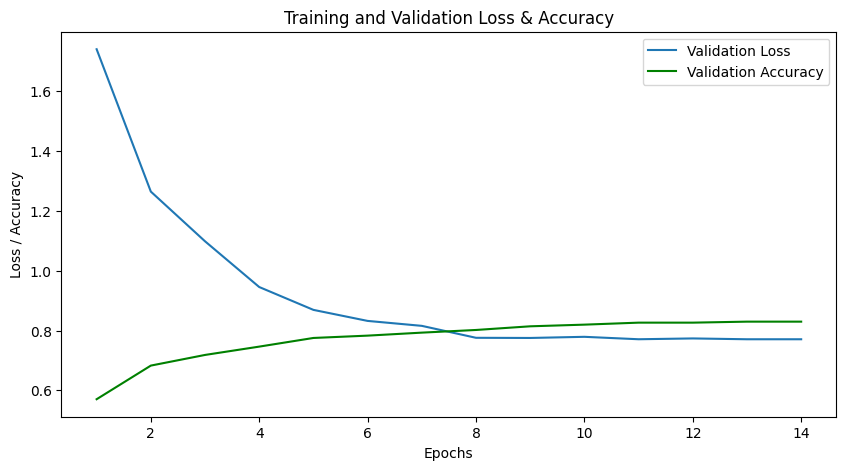

In [26]:
# Supponendo che trainer.state.log_history contenga la storia dei log
log_history = trainer.state.log_history

# Estrai i dati di training
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
eval_accuracy = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]

# Crea una lista di epoche per il plot
epochs = range(1, len(eval_loss) + 1)

# Crea il plot
plt.figure(figsize=(10, 5))

# Plot della Loss
plt.plot(epochs, eval_loss, label='Validation Loss')

# Plot dell'Accuracy (su un asse secondario)
plt.plot(epochs, eval_accuracy, label='Validation Accuracy', color='green')

# Aggiungi etichette e titolo
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Loss & Accuracy')
plt.legend(loc='upper right')

# Mostra il plot
plt.show()

In [ ]:
torch.cuda.empty_cache()

##Modello - Predizioni

In [27]:
# Passo 1: Esegui le predizioni
predictions = trainer.predict(test_dataset)

# Passo 2: Estrai le predizioni e le label vere
logits = predictions.predictions
pred_labels = np.argmax(logits, axis=1)

# Converti le etichette predette nelle campagne corrispondenti
pred_campaigns = [label_to_campaign[label] for label in pred_labels]

# Estrai le label vere dal dataset
true_labels = [label_to_campaign[label] for label in test_dataset.labels]

# Passo 3: Stampa i risultati
for i in range(len(test_dataset)):
    text = test_dataset[i]['text']  # Testo originale
    true_label = true_labels[i]  # Label vera (campagna originale)
    pred_label = pred_campaigns[i]  # Predizione (campagna predetta)
    id_art = test_dataset[i]['idArt']  # ID dell'articolo

    print(f"ID ART: {id_art}")
    print(f"TUPLA: {text}")
    print(f"CAMPAGNA VERA: {true_label}")
    print(f"CAMPAGNA PREDETTA: {pred_label}")
    print("-" * 30)

ID ART: 11958
TUPLA: Hitting them - results - in civilian deaths
CAMPAGNA VERA: Disinformation on armed forces for Ukraine
CAMPAGNA PREDETTA: Disinformation on armed forces for Ukraine
------------------------------
ID ART: 12127
TUPLA: Cipro - caused - Jeff to enter the “fluoroquinolone Twilight Zone”
CAMPAGNA VERA: Vaccines and illnesses fake news
CAMPAGNA PREDETTA: Vaccines and illnesses fake news
------------------------------
ID ART: 11768
TUPLA: Group - will function - as “Global Climate Intelligence Group”
CAMPAGNA VERA: Climate Change Denial
CAMPAGNA PREDETTA: Climate Change Denial
------------------------------
ID ART: 12022
TUPLA: Safety - is - neglected
CAMPAGNA VERA: Medical Fake News
CAMPAGNA PREDETTA: Medical Fake News
------------------------------
ID ART: 12105
TUPLA: Critics - argue - factors
CAMPAGNA VERA: Transgender Athlete
CAMPAGNA PREDETTA: Transgender Athlete
------------------------------
ID ART: 11834
TUPLA: Erin Elizabeth - wrote - my heart goes out to the fam

In [28]:
df_results = pd.DataFrame({
    'TUPLA': test_texts,
    'CAMPAGNA': true_labels,
    'CAMPAGNA PREDETTA': pred_campaigns,
    'ID ARTICOLO': test_ids
})

In [ ]:
#df_results.head(1000)

##Risultati predizioni

**ACCURATEZZA TOT SU NUM DI TUPLE**

In [29]:
numero_tuple_tot = df_results.shape[0]
numero_tuple_corrette = df_results[df_results['CAMPAGNA'] == df_results['CAMPAGNA PREDETTA']].shape[0]
accuracy= numero_tuple_corrette / numero_tuple_tot
print(f"Accuracy su numero di tuple: {accuracy}")

Accuracy su numero di tuple: 0.8051224944320713


In [30]:
# Ottieni la lista delle campagne uniche in df_confronto_final
campagne = df_results['CAMPAGNA'].unique()

# Crea un dizionario di contatori inizializzati a 0
contatori_campagne = {campagna: 0 for campagna in campagne}

# Visualizza il dizionario per verificare
#print(contatori_campagne)

df_results['Campagna VOTING'] = 'Non Assegnata'

In [31]:
# Raggruppa il DataFrame per ID ARTICOLO
grouped = df_results.groupby('ID ARTICOLO')

for articolo_id, gruppo in grouped:
    # Reimposta i contatori a 0 per ogni nuovo articolo
    contatori_campagne = {campagna: 0 for campagna in campagne}

    # Conta le occorrenze di ciascuna campagna nel gruppo corrente
    for campagna in gruppo['CAMPAGNA PREDETTA']:
        contatori_campagne[campagna] += 1

    # Trova il massimo dei contatori
    campagna_massima = max(contatori_campagne, key=contatori_campagne.get)
    valore_massimo = contatori_campagne[campagna_massima]
    # print(f"Articolo ID: {articolo_id}")
    # print(f"Valore massimo: {campagna_massima}")

    # Aggiungi il risultato alla colonna 'Campagna VOTING'
    df_results.loc[df_results['ID ARTICOLO'] == articolo_id, 'Campagna VOTING'] = campagna_massima


In [ ]:
#df_results.to_excel('df_results.xlsx', index=False)

**ACCURATEZZA SU NUM DI ARTICOLI**

In [32]:
# Conta il numero di articoli totali
num_articoli_totali = df_results['ID ARTICOLO'].nunique()

print(f"Numero totale di articoli: {num_articoli_totali}")

# Filtra le righe in cui 'CAMPAGNA' è uguale a 'Campagna Assegnata'
righe_filtrate = df_results[df_results['CAMPAGNA'] == df_results['Campagna VOTING']]

# Conta il numero di ID ARTICOLO unici tra le righe filtrate
numero_di_articoli_corrispondenti = righe_filtrate['ID ARTICOLO'].nunique()
print(f"Numero di articoli corrispondenti: {numero_di_articoli_corrispondenti}")

# Calcola l'accuratezza per il threshold attuale
accuracy_art = numero_di_articoli_corrispondenti / num_articoli_totali

print(f"Accuratezza per articolo:", accuracy_art)

Numero totale di articoli: 485
Numero di articoli corrispondenti: 386
Accuratezza per articolo: 0.7958762886597938


In [ ]:
# # Step 8: Save the Model
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_tokenizer')

('./saved_tokenizer/tokenizer_config.json',
 './saved_tokenizer/special_tokens_map.json',
 './saved_tokenizer/vocab.txt',
 './saved_tokenizer/added_tokens.json')

In [ ]:
import zipfile
import os

# Definisci i nomi delle cartelle e del file ZIP
model_dir = './saved_model'
tokenizer_dir = './saved_tokenizer'
zip_filename = 'model_and_tokenizer.zip'

# Crea un file ZIP
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Aggiungi la cartella del modello al file ZIP
    for root, dirs, files in os.walk(model_dir):
        for file in files:
            filepath = os.path.join(root, file)
            arcname = os.path.relpath(filepath, model_dir)
            zipf.write(filepath, os.path.join('saved_model', arcname))

    # Aggiungi la cartella del tokenizer al file ZIP
    for root, dirs, files in os.walk(tokenizer_dir):
        for file in files:
            filepath = os.path.join(root, file)
            arcname = os.path.relpath(filepath, tokenizer_dir)
            zipf.write(filepath, os.path.join('saved_tokenizer', arcname))

print(f'File ZIP creato: {zip_filename}')


File ZIP creato: model_and_tokenizer.zip
